In [1]:
!date

Mon Nov  9 09:42:54 PST 2020


# Merfish v smartseq compare gene subclass

In [151]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy.sparse import csr_matrix
from scipy import stats
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from scipy.spatial import ConvexHull
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/trackfig')
from trackfig.utils import get_notebook_name
from trackfig.trackfig import trackfig 

TRACKFIG = "/home/sina/projects/mop/BYVSTZP_2020/trackfig.txt"
NB = get_notebook_name()


import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [93]:
def nd(arr):
    return np.asarray(arr).reshape(-1)

In [43]:
unique_map = {'Astrocytes': "Astro",
'Endothelial':"Endo",
'SMC':"SMC",
'L23_IT':"L2/3 IT",
'VLMC': "VLMC",
'L6_CT': "L6 CT",
'L45_IT': "L4/5 IT",
'L5_PT': "L5 PT",
'L5_IT': "L5 IT",
'Sst': "Sst",
'L6_IT': "L6 IT",
'Sncg': "Sncg",
'L6_IT_Car3': "L6 IT Car3",
'Vip': "Vip",
'L56_NP': "L5/6 NP",
'Pvalb': "Pvalb",  
'L6b': "L6b",
'Lamp5': "Lamp5"}

inv_map = {v: k for k, v in unique_map.items()}

In [96]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [84]:
def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def group_mtx_by_cluster(mtx, components, features, s2t, source_id="cell_id", target_id="subclass_label", by="components"):
    """
    mtx: ndarray components by features 
    components: labels for rows of mtx
    features: labels for columns of mtx
    s2t: pandas dataframe mapping source (features or components) to a
    targets features(components) to group by
    target_id: column name in s2t to group by
    """
    if target_id not in s2t.columns: return -1
    
    ncomp   = components.shape[0]
    nfeat   = features.shape[0]
    ntarget = s2t[target_id].nunique()
    
    if by =="features": 
        source = features
    elif by =="components": 
        source = components
    
    # Map the source to an index
    source2idx = dict(zip(source, range(len(source))))
    # Map the target to a list of source indices
    target2idx = (s2t.groupby(target_id)[source_id].apply(lambda x: [source2idx[i] for i in x])).to_dict()
    
    # array of unique targets
    unique = s2t[target_id].unique().astype(str)
    nuniq = unique.shape[0]
    X = np.zeros((nuniq, mtx.shape[1]))
    
    for tidx, t in enumerate(unique):
        # Grab the matrix indices corresponding to columns and source columns to group by
        source_indices = target2idx[t]
        #print(source_indices)
        
        # breaks generality
        sub_mtx = mtx[source_indices,:].mean(axis=0) # Sum on source indicies
        X[tidx,:] = sub_mtx # place summed vector in new matrix
        
    # Return matrix that is grouped by
    return (X, components, unique)

# Merfish

In [203]:
adata = anndata.read_h5ad("../../data/notebook/revision/merfish-updated.h5ad")

In [204]:
ss = anndata.read_h5ad("../../data/notebook/revision/no_filter_smartseq_gene.h5ad")
ss = ss[ss.obs.eval("subclass_label!='Low Quality'")]

md = pd.read_csv("../../reference/smart-seq_cluster_labels/sample_metadata.csv", index_col = 0)
ss.obs["sex"] = ss.obs.cell_id.map(md["gender"])

Trying to set attribute `.obs` of view, copying.


In [205]:
print(ss)
print(adata)

AnnData object with n_obs × n_vars = 6283 × 31053
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'sex'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'
AnnData object with n_obs × n_vars = 280327 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'label', 'subclass', 'class_label', 'cell_id'
    var: 'n_iso'
    layers: 'X', 'log1p', 'norm'


# Match the subclasses and the genes

In [206]:
ss_genes = ss.var.gene_name.str.split("_").apply(lambda x: "".join(x[:-1])).values
adata_genes = adata.var.index.values

common_genes = np.intersect1d(ss_genes, adata_genes)

ss.var["gene_name_only"] = ss.var.gene_name.str.split("_").apply(lambda x: "".join(x[:-1])).values

mfish = adata[:,adata.var.index.isin(common_genes)]
ss = ss[:,ss.var.gene_name_only.isin(common_genes)]

ss = ss[:,ss.var.sort_values("gene_name_only").index]
mfish = mfish[:,mfish.var.sort_index().index]

ss.obs["subclass_label"] = ss.obs["subclass_label"].values.astype(str)
mfish.obs["subclass"] = mfish.obs["subclass"].values.astype(str)

mfish.obs["ss_subclass"] = mfish.obs["subclass"].apply(lambda x: unique_map.get(x, "None"))
mfish = mfish[mfish.obs.ss_subclass != "None"]

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [207]:
False in (mfish.var.index.values == ss.var.gene_name_only.values)

False

In [208]:
unique = np.intersect1d(np.unique(mfish.obs.ss_subclass.values), np.unique(ss.obs.subclass_label.values))

ss.obs.subclass_label.value_counts().sort_index()[unique].index == mfish.obs.ss_subclass.value_counts().sort_index()[unique].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

# Process

In [209]:
ss.layers

Layers with keys: 

In [210]:
ss.layers["norm"] = normalize(ss.X, norm='l1', axis=1)*1000000 # X here is scaled matrix by length
ss.layers["log1p"] = csr_matrix(np.log1p(ss.layers["norm"]))

In [211]:
%%time
mat = ss.layers["log1p"].todense()
mtx = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
ss.X = mtx

CPU times: user 41 ms, sys: 1.7 ms, total: 42.7 ms
Wall time: 41.4 ms


In [212]:
np.setdiff1d(adata_genes, ss_genes)

array([], dtype=object)

# Perform subclass comparison

In [213]:
mfish_mat = mfish.X
mfish_ass = mfish.obs.ss_subclass.values

ss_mat = ss.X
ss_ass = ss.obs.subclass_label.values

In [214]:
%%time
rvals = []
ss_x = []
mfish_x = []

for uidx, u in enumerate(unique):
    mfish_t_mat, _ = split_by_target(mfish_mat, mfish_ass, u)
    ss_t_mat, _ = split_by_target(ss_mat, ss_ass, u)
    
    
    mf = np.asarray(mfish_t_mat.mean(axis=0)).reshape(-1)
    s = np.asarray(ss_t_mat.mean(axis=0)).reshape(-1)
    
    ss_x.append(s)
    mfish_x.append(mf)
    
    r, p = stats.pearsonr(mf, s)
    rvals.append(r)
    print("[{} of {}] {:,.2f}: {}".format(uidx+1, unique.shape[0],r, u) )

[1 of 17] 0.56: Astro
[2 of 17] 0.65: Endo
[3 of 17] 0.78: L2/3 IT
[4 of 17] 0.44: L5 IT
[5 of 17] 0.77: L5 PT
[6 of 17] 0.85: L5/6 NP
[7 of 17] 0.81: L6 CT
[8 of 17] 0.80: L6 IT
[9 of 17] 0.73: L6 IT Car3
[10 of 17] 0.88: L6b
[11 of 17] 0.88: Lamp5
[12 of 17] 0.86: Pvalb
[13 of 17] 0.65: SMC
[14 of 17] 0.84: Sncg
[15 of 17] 0.82: Sst
[16 of 17] 0.69: VLMC
[17 of 17] 0.80: Vip
CPU times: user 934 ms, sys: 797 ms, total: 1.73 s
Wall time: 1.72 s


In [215]:
ss_size = ss.obs["subclass_label"].value_counts()[unique]

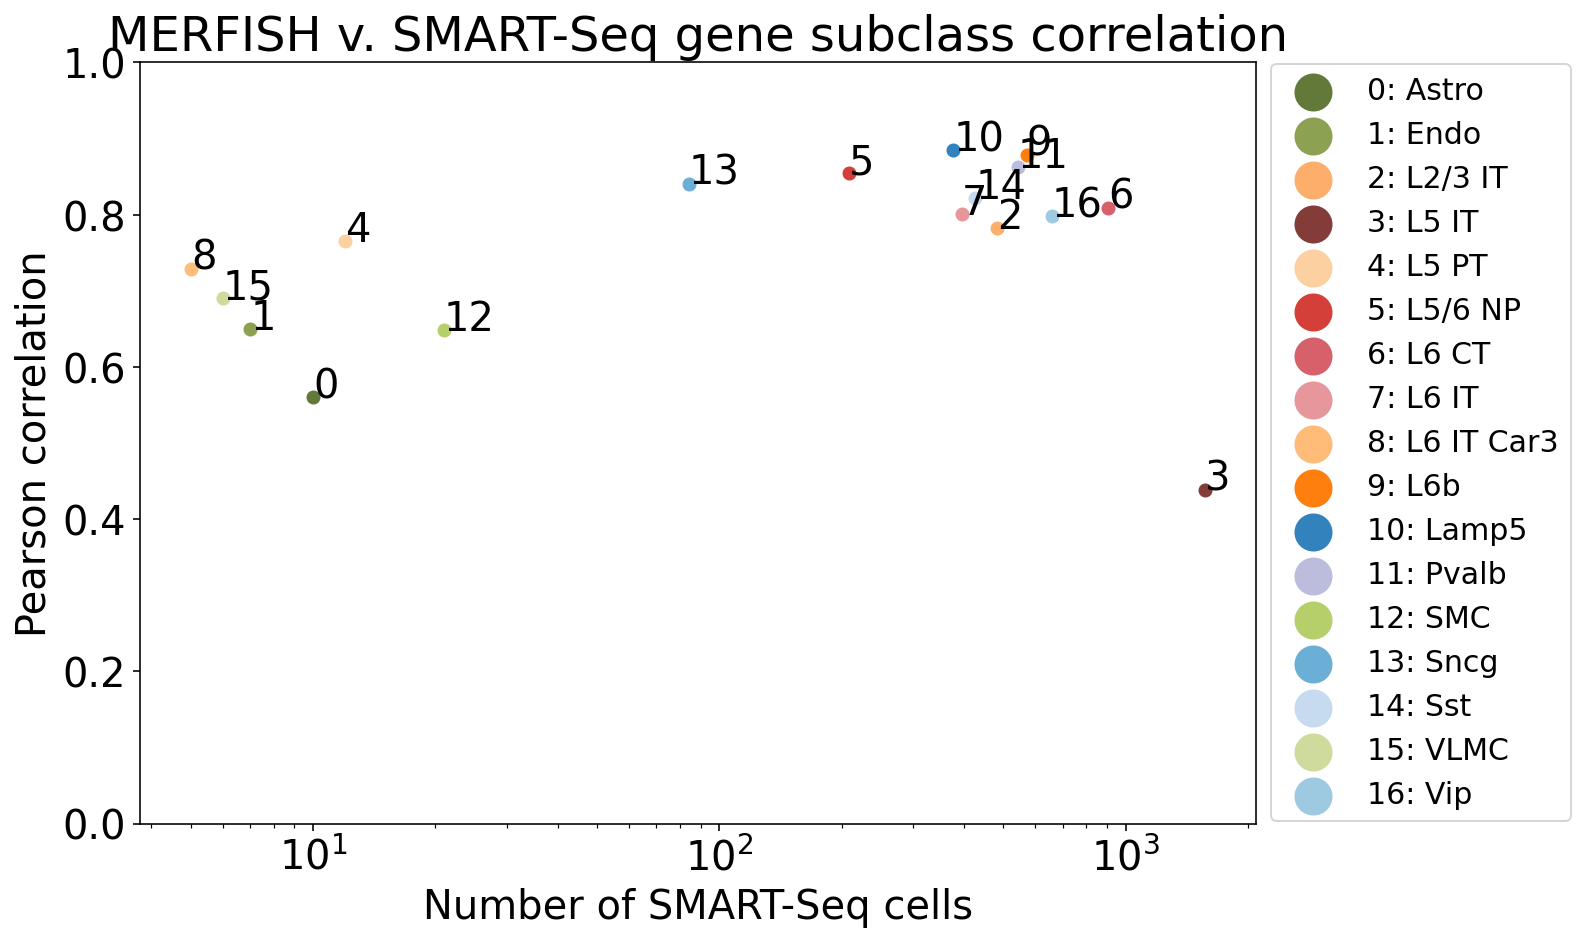

In [216]:
fig, ax = plt.subplots(figsize=(10,7))

x = ss_size
y = rvals

for i, txt in enumerate(unique):
    ax.annotate(i, (x[i], y[i]))
    ax.scatter(x[i], y[i], label="{}: {}".format(i, txt), color=cluster_cmap[txt])
ax.set_ylim((0, 1))
ax.set_xscale("log")
    
ax.set_xlabel("Number of SMART-Seq cells")
ax.set_ylabel("Pearson correlation")
ax.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5), markerscale=3)
ax.set_title("MERFISH v. SMART-Seq gene subclass correlation")

plt.savefig(trackfig("../../figures/merfish-updated_smartseq_subclass_correlation_size.png", TRACKFIG, NB), bbox_inches='tight', dpi=300)
plt.show()

In [217]:
pd.Series(rvals, unique.tolist())

Astro         0.560322
Endo          0.649607
L2/3 IT       0.782075
L5 IT         0.438288
L5 PT         0.765639
L5/6 NP       0.854184
L6 CT         0.808893
L6 IT         0.800460
L6 IT Car3    0.729122
L6b           0.878975
Lamp5         0.884550
Pvalb         0.862566
SMC           0.648200
Sncg          0.840859
Sst           0.822352
VLMC          0.690226
Vip           0.798165
dtype: float64

In [218]:
rvals

[0.5603222275508296,
 0.6496069144954573,
 0.7820752907848809,
 0.4382881498595573,
 0.7656392114133692,
 0.8541842713888791,
 0.808893407121526,
 0.8004600458202673,
 0.7291220376622998,
 0.8789746186046652,
 0.8845497565028714,
 0.8625655492899029,
 0.6482002027225622,
 0.8408586805067313,
 0.8223515323593641,
 0.6902258942533921,
 0.7981647746280334]

In [219]:
unique.tolist()

['Astro',
 'Endo',
 'L2/3 IT',
 'L5 IT',
 'L5 PT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'Lamp5',
 'Pvalb',
 'SMC',
 'Sncg',
 'Sst',
 'VLMC',
 'Vip']

In [220]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

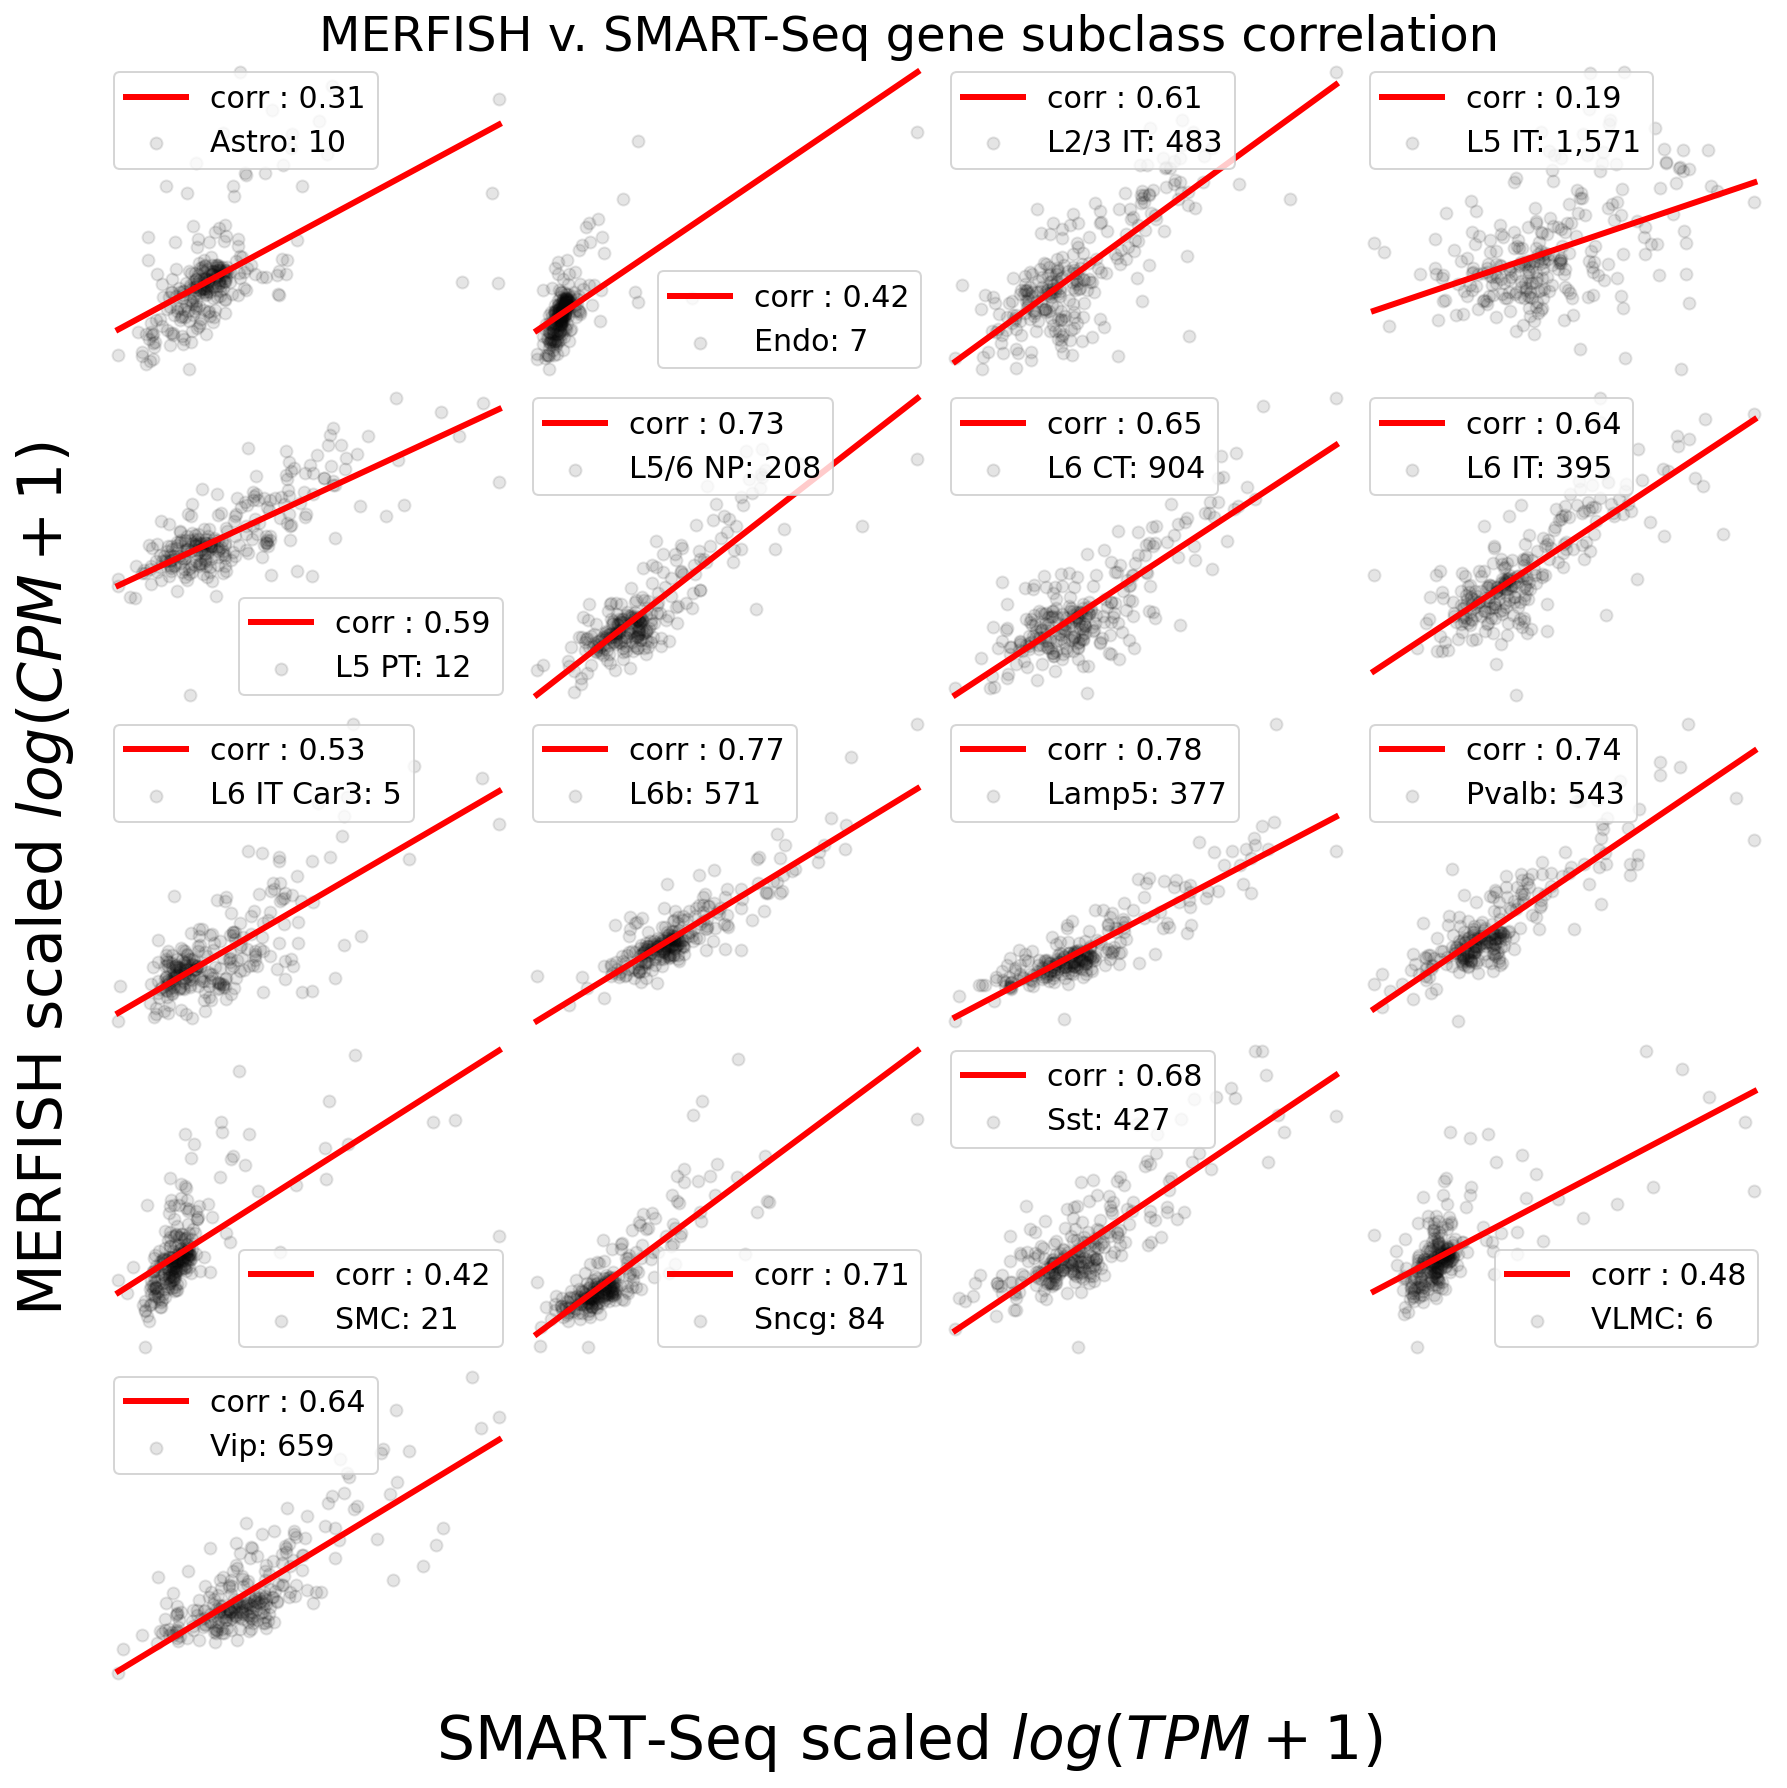

In [221]:
fig, ax = plt.subplots(figsize=(15,15), ncols=4, nrows=5)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, len(unique))
fig.suptitle('MERFISH v. SMART-Seq gene subclass correlation', y=0.9)


for cidx, (ax, c) in enumerate(zip(axs, unique)):
    
    
    x = ss_x[cidx]
    y = mfish_x[cidx]

    
    ax.scatter(x, y, label="{}: {:,}".format(c, ss_size[cidx]), color="k", alpha=0.1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    minx = min(x)
    maxx = max(x)
    x = np.linspace(minx, maxx, 10)
    y = slope*x+intercept
    ax.plot(x, y, label="corr : {:,.2f}".format(r_value**2), color="red", linewidth=3)
    ax.legend(fontsize=15)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_axis_off()
fig.text(0.5, 0.1, 'SMART-Seq scaled $log(TPM+1)$', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, 'MERFISH scaled $log(CPM+1)$', ha='center', va='center', rotation='vertical', fontsize=30)
plt.savefig(trackfig("../../figures/merfish-updated_smartseq_subclass_correlation_scatter.png", TRACKFIG, NB), bbox_inches='tight',dpi=300)

plt.show()

In [202]:
rvals

[0.44439937922120604,
 0.6587760161783072,
 0.7742783222898925,
 0.3808001845021517,
 0.6991469993193609,
 0.8553235878774621,
 0.8118545590836792,
 0.807080754000068,
 0.6498023727840828,
 0.8793411979853577,
 0.8875971655410971,
 0.8559364439953152,
 0.647458173359182,
 0.8445975653228733,
 0.8269098745994988,
 0.6479261337746445,
 0.7990911676484398]

In [201]:
unique.tolist()

['Astro',
 'Endo',
 'L2/3 IT',
 'L5 IT',
 'L5 PT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'Lamp5',
 'Pvalb',
 'SMC',
 'Sncg',
 'Sst',
 'VLMC',
 'Vip']